In [1]:
# ALWAYS RUN THIS CELL
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import numpy as np

import tensorly as tl

In [3]:
%load_ext autoreload
%autoreload 2
import bnpm

Import data

In [4]:
directory_data_tca = r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/run_20230701/'

In [5]:
paths_data_tca = bnpm.path_helpers.find_paths(
    dir_outer=directory_data_tca,
    reMatch='VQT_Analyzer.h5',
    depth=3,
    natsorted=True,
)
dates_data_tca = [Path(p).parts[-4] for p in paths_data_tca]

dates_data_tca

['20230430',
 '20230501',
 '20230502',
 '20230503',
 '20230504',
 '20230505',
 '20230506',
 '20230507',
 '20230508',
 '20230509',
 '20230510',
 '20230511',
 '20230512',
 '20230514',
 '20230515',
 '20230516',
 '20230517',
 '20230518',
 '20230519',
 '20230520',
 '20230521',
 '20230522',
 '20230523',
 '20230524',
 '20230525',
 '20230526',
 '20230527',
 '20230528',
 '20230529',
 '20230530',
 '20230531',
 '20230601']

In [6]:
data_tca = {d: bnpm.h5_handling.simple_load(p, return_dict=False,) for d,p in tqdm(zip(dates_data_tca, paths_data_tca))}

0it [00:00, ?it/s]

make a subsampled and concatenated version

In [13]:
n_samples_per_session = 2000

spectrograms_subsampled = {}

for date, data in tqdm(data_tca.items()):
    idx = np.sort(np.random.choice(np.arange(data['spectrograms']['0'].shape[-1]), size=min(n_samples_per_session, data['spectrograms']['0'].shape[-1]), replace=False))

    spectrograms_subsampled[date] = data['spectrograms']['0'][..., idx]

  0%|          | 0/32 [00:00<?, ?it/s]

In [37]:
DEVICE_bigTCA = bnpm.torch_helpers.set_device(use_GPU=False)

device: 'cpu'


In [18]:
spectrograms_cat = np.concatenate(list(spectrograms_subsampled.values()), axis=-1)

In [19]:
spectrograms_cat = spectrograms_cat.transpose(-1, 2, 0, 1)
spectrograms_cat = spectrograms_cat.reshape(spectrograms_cat.shape[0], spectrograms_cat.shape[1], -1)
spectrograms_cat = torch.as_tensor(spectrograms_cat, dtype=torch.float32, device=DEVICE_bigTCA)

In [29]:
# np.save('/media/rich/bigSSD/downloads_tmp/spec_cat.npy', spectrograms_cat.numpy())

In [30]:
# spectrograms_cat = np.load('/media/rich/bigSSD/downloads_tmp/spec_cat.npy')

In [20]:
bnpm.misc.estimate_array_size(spectrograms_cat)

17.252352

In [21]:
bnpm.torch_helpers.clear_cuda_cache()

In [23]:
tl.set_backend('pytorch')

In [24]:
model = tl.decomposition.CP_NN_HALS(
    rank=10,
    n_iter_max=100,
    init='random',
    svd='truncated_svd',
    tol=1e-07,
    sparsity_coefficients=None,
    fixed_modes=None,
    nn_modes='all',
    exact=False,
    verbose=True,
#     normalize_factors=False,
#     cvg_criterion='abs_rec_error',
#     random_state=None,
)

In [25]:
model.fit(spectrograms_cat)

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/roicat/lib/python3.11/site-packages/tensorly/backend/pytorch_backend.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(


reconstruction error=0.32663604617118835
iteration 1, reconstruction error: 0.5896908640861511, decrease = -0.26305481791496277
iteration 2, reconstruction error: 0.6161264181137085, decrease = -0.026435554027557373
iteration 3, reconstruction error: 0.6261373162269592, decrease = -0.010010898113250732
iteration 4, reconstruction error: 0.6309921741485596, decrease = -0.004854857921600342
iteration 5, reconstruction error: 0.6339074969291687, decrease = -0.002915322780609131
iteration 6, reconstruction error: 0.6359459757804871, decrease = -0.0020384788513183594
iteration 7, reconstruction error: 0.6377460360527039, decrease = -0.0018000602722167969
iteration 8, reconstruction error: 0.6394460201263428, decrease = -0.001699984073638916
iteration 9, reconstruction error: 0.6408548355102539, decrease = -0.0014088153839111328
iteration 10, reconstruction error: 0.6418330669403076, decrease = -0.000978231430053711
iteration 11, reconstruction error: 0.6424534320831299, decrease = -0.000620

Rank-10 Non-Negative CP decomposition.

In [26]:
factors = model.decomposition_.factors

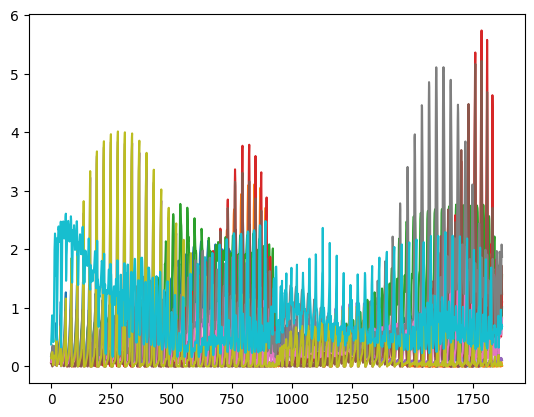

In [27]:
plt.figure()
plt.plot(factors[2].cpu())

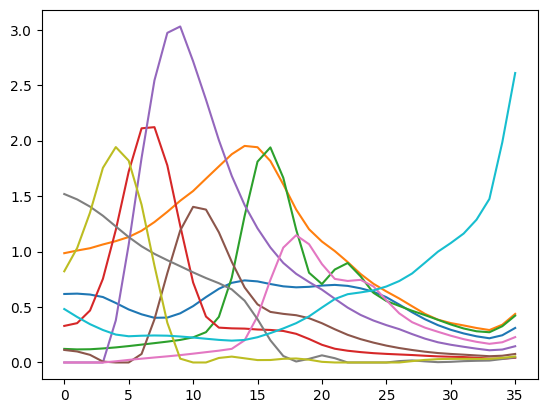

In [28]:
plt.figure()
plt.plot(factors[1].cpu())

rearrange factors

In [35]:
factors_named = {
    'time': factors[0],
    'frequency': factors[1],
    '(points (xy))': factors[2],
}

Save factors

In [36]:
bnpm.h5_handling.simple_save(
    dict_to_save=factors_named,
    path=r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/run_20230701/bigTCA.h5',
)

refit temporal factor for each day

In [40]:
DEVICE_smallTCA = bnpm.torch_helpers.set_device(use_GPU=True)

devices available: [_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)]
Using device: 'cuda:0': _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)


In [75]:
init_bt = tl.cp_tensor.CPTensor((None, [torch.as_tensor(t, dtype=torch.float32, device='cpu') for t in factors[:]]))

In [74]:
import copy

In [86]:
    bnpm.torch_helpers.clear_cuda_cache()

In [113]:
factors_refit = {}
for date, data in tqdm(data_tca.items()):
    data_rs = torch.as_tensor(data['spectrograms']['0'][:], dtype=torch.float32, device='cpu')
    
    data_rs = data_rs.permute(-1, 2, 0, 1)
    data_rs = data_rs.reshape(data_rs.shape[0], data_rs.shape[1], -1).permute(1,2,0)
    data_rs = data_rs.to(DEVICE_smallTCA)
    
    init_bt_i = copy.deepcopy(init_bt).factors
    init_bt_i[0] = init_bt_i[0][torch.randint(low=0, high=init_bt_i[0].shape[0], size=(data_rs.shape[2],)), :]
    init_bt_i = [torch.as_tensor(t, dtype=torch.float32, device=DEVICE_smallTCA) for t in init_bt_i]
    init_bt_i = [init_bt_i[ii] for ii in [1,2,0]]

    model = tl.decomposition.CP_NN_HALS(
        rank=10,
        n_iter_max=100,
#         init='random',
        init=tl.cp_tensor.CPTensor((None, init_bt_i)),
        svd='truncated_svd',
        tol=1e-07,
        sparsity_coefficients=None,
        fixed_modes=[0,1],
        nn_modes='all',
        exact=False,
        verbose=True,
    #     normalize_factors=False,
    #     cvg_criterion='abs_rec_error',
    #     random_state=None,
    )
    
    model.fit(tensor=data_rs)
    
    factors_refit[date] = copy.deepcopy(model.decomposition_.factors)
    
    del data_rs
    bnpm.torch_helpers.clear_cuda_cache()

  0%|          | 0/32 [00:00<?, ?it/s]

reconstruction error=0.43965479731559753
iteration 1, reconstruction error: 0.43965479731559753, decrease = 0.0
PARAFAC converged after 1 iterations
reconstruction error=0.4513958692550659
iteration 1, reconstruction error: 0.451396107673645, decrease = -2.384185791015625e-07
iteration 2, reconstruction error: 0.4513958692550659, decrease = 2.384185791015625e-07
iteration 3, reconstruction error: 0.451396107673645, decrease = -2.384185791015625e-07
iteration 4, reconstruction error: 0.4513958692550659, decrease = 2.384185791015625e-07
iteration 5, reconstruction error: 0.451396107673645, decrease = -2.384185791015625e-07
iteration 6, reconstruction error: 0.451396107673645, decrease = 0.0
PARAFAC converged after 6 iterations
reconstruction error=0.4457342326641083
iteration 1, reconstruction error: 0.4457339346408844, decrease = 2.980232238769531e-07
iteration 2, reconstruction error: 0.4457339346408844, decrease = 0.0
PARAFAC converged after 2 iterations
reconstruction error=0.4586659

In [ ]:
dict_keys(['(xy points)', 'frequency', 'time'])

In [133]:
factors_refit_named = {date: {
    '(xy points)': f[1].cpu().numpy(),
    'frequency': f[0].cpu().numpy(),
    'time': f[2].cpu().numpy(),
} for date, f in factors_refit.items()}

In [135]:
factors_refit_separated = {date: {'factors_rearranged': {'0': f}} for date, f in factors_refit_named.items()}

In [127]:
bnpm.h5_handling.simple_save(
    dict_to_save=factors_refit_named,
    path=r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/run_20230701/factors_refit_bigTCA.h5',
    write_mode='w'
)

In [138]:
[bnpm.h5_handling.simple_save(
    dict_to_save=f,
    path=f'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/run_20230701/factors_refit/{date}/TCA.h5',
    write_mode='w',
) for date, f in factors_refit_separated.items()]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]